### Prototyping the Analysis Pipeline for the Oberisk

This notebook demonstrates a complete data science pipeline for obesity risk prediction, including:  
1. Descriptive Analytics  
2. Diagnostic Analytics  
3. Predictive Analytics  
4. Prescriptive Analytics  

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import pickle, shap, time, joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

# Set unified font size and style
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
colors = ['#F7F0D4', '#A5C2A7', '#C3D2E0', '#A5B8D6', '#E8C4B8', '#D49A89', '#B36A5E']


# Load dataset
df = pd.read_csv('../assets/ObesityDataSet_raw_and_data_sinthetic.csv')

# Simple cleaning
df = df.drop_duplicates().dropna().reset_index(drop=True)
df.columns = df.columns.str.strip()
df = df.rename(columns={"Age": "age",
                        "Gender":"sex",
                        "Weight": "weight",
                        "Height": "height",
                        "family_history_with_overweight": "family_history",
                        "FAVC": "often_high_calorie_intake",
                        "FCVC": "veggie_per_meal",
                        "NCP": "meals_daily",
                        "CAEC": "freq_snack",
                        "SMOKE": "smoking",
                        "CH2O": "water_daily",
                        "SCC": "monitor_calorie",
                        "FAF": "physical_activity",
                        "TUE": "technological_devices",
                        "CALC": "freq_alcohol",
                        "MTRANS": "transport",
                        "NObeyesdad": "bmi_category"
                          })
target = "bmi_category"

# Numerical/Categorical Variables
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.drop(target).tolist()

print("Data shape:", df.shape)
print("Numerical variables:", numeric_cols)
print("Categorical variables:", categorical_cols)
print("Missing values:\n", df.isnull().sum())

print("\nNumerical variables statistics:")
display(df[numeric_cols].describe().T)
print("\nCategorical variables cardinality:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()}")

y_multiclass = df[target]
X = df[numeric_cols + categorical_cols]


Data shape: (2087, 17)
Numerical variables: ['age', 'height', 'weight', 'veggie_per_meal', 'meals_daily', 'water_daily', 'physical_activity', 'technological_devices']
Categorical variables: ['sex', 'family_history', 'often_high_calorie_intake', 'freq_snack', 'smoking', 'monitor_calorie', 'freq_alcohol', 'transport']
Missing values:
 sex                          0
age                          0
height                       0
weight                       0
family_history               0
often_high_calorie_intake    0
veggie_per_meal              0
meals_daily                  0
freq_snack                   0
smoking                      0
water_daily                  0
monitor_calorie              0
physical_activity            0
technological_devices        0
freq_alcohol                 0
transport                    0
bmi_category                 0
dtype: int64

Numerical variables statistics:


,count,mean,std,min,25%,50%,75%,max
age,2087.0,24.353090,6.368801,14.00,19.915937,22.847618,26.000000,61.00
height,2087.0,1.702674,0.093186,1.45,1.630178,1.701584,1.769491,1.98
weight,2087.0,86.858730,26.190847,39.00,66.000000,83.101100,108.015907,173.00
veggie_per_meal,2087.0,2.421466,0.534737,1.00,2.000000,2.396265,3.000000,3.00
meals_daily,2087.0,2.701179,0.764614,1.00,2.697467,3.000000,3.000000,4.00
water_daily,2087.0,2.004749,0.608284,1.00,1.590922,2.000000,2.466193,3.00
physical_activity,2087.0,1.012812,0.853475,0.00,0.124505,1.000000,1.678102,3.00
technological_devices,2087.0,0.663035,0.608153,0.00,0.000000,0.630866,1.000000,2.00



Categorical variables cardinality:
sex: 2
family_history: 2
often_high_calorie_intake: 2
freq_snack: 4
smoking: 2
monitor_calorie: 2
freq_alcohol: 4
transport: 5


### 1-Descriptive Analytics
This section explores key patterns in the dataset through summary statistics and visualizations.  
We aim to answer:  
1. What is the distribution across the seven obesity levels?  
2. How do age differ across categories?  
3. How do family history differ across categories?  
4. How are numeric variables correlated?
5. How are categorical variables related with each other?

✨ Below are the codes and visualization for these 5 questions.  
✨ More codes for descriptive analytics please refer to test_data_analysis.ipynb.

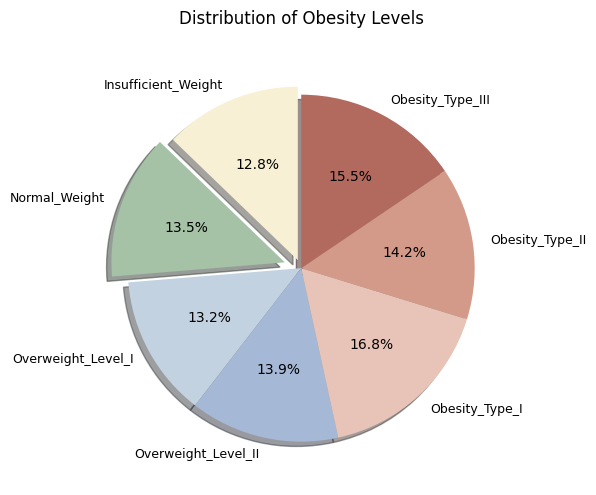

C:\Users\Huawei\AppData\Local\Temp\ipykernel_31672\2572230197.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bmi_category', y='age', data=df, order=category_order, palette=colors)


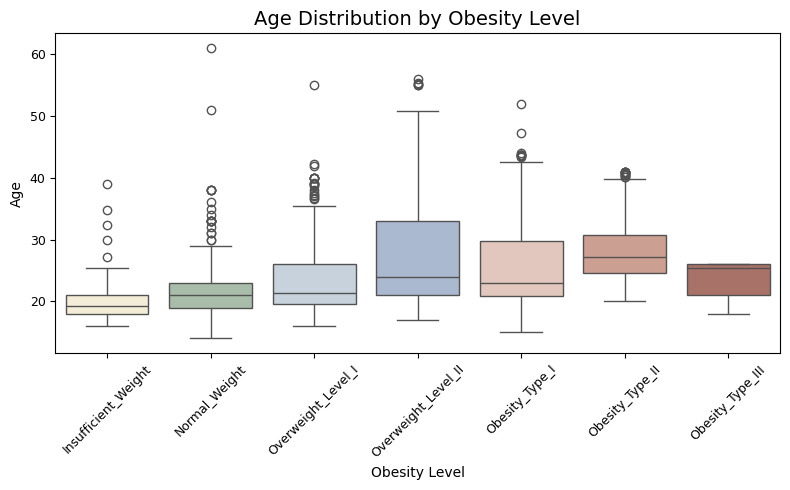

<Figure size 800x500 with 0 Axes>

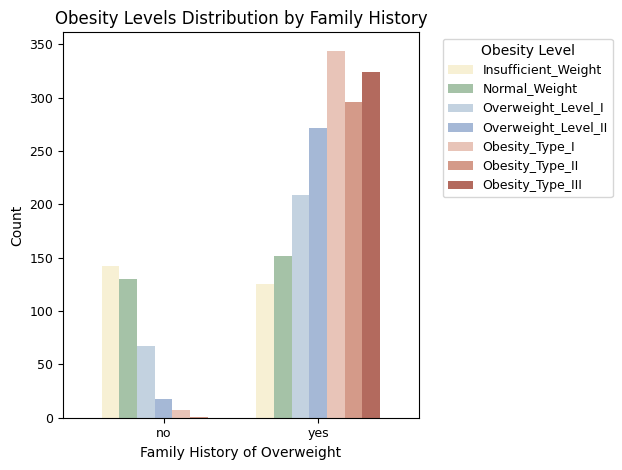

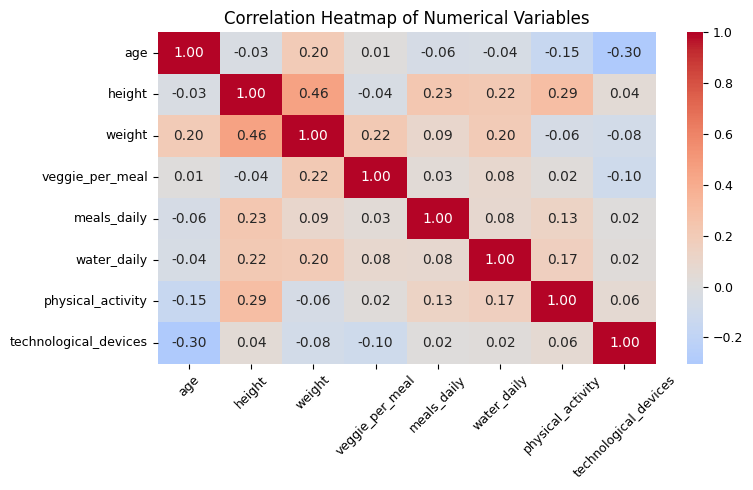

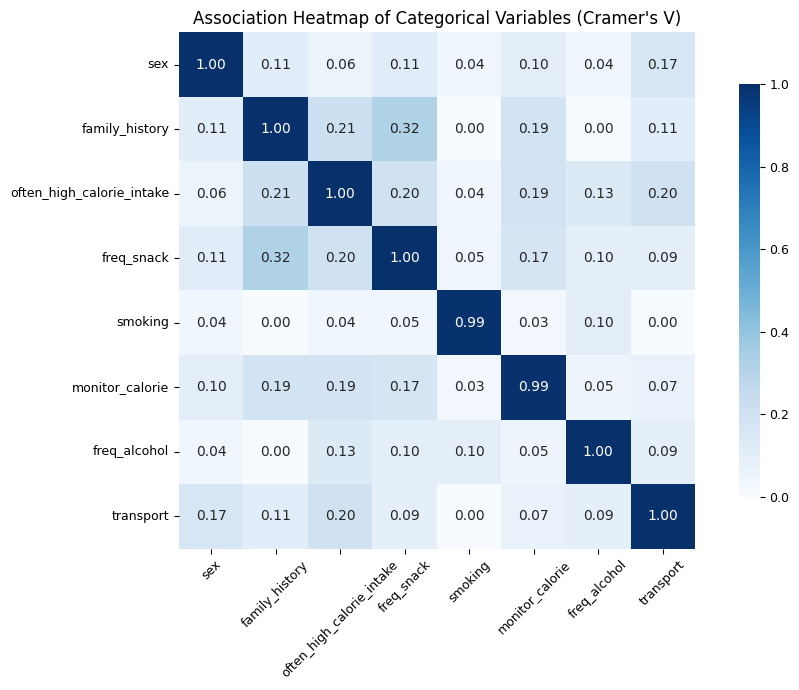

In [15]:
# 1. Distribution of categories
plt.figure(figsize=(6, 6))
category_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
                  'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
counts = y_multiclass.value_counts()
counts = counts.reindex(category_order)
explode = (0.05, 0.1, 0, 0, 0, 0, 0)
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors, shadow=True)
plt.title("Distribution of Obesity Levels", pad=20)
plt.ylabel("")
plt.tight_layout()
plt.show()

# 2. Age across categories
plt.figure(figsize=(8, 5))
sns.boxplot(x='bmi_category', y='age', data=df, order=category_order, palette=colors)
plt.title('Age Distribution by Obesity Level', fontsize=14)
plt.xlabel('Obesity Level')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Family history across categories
plt.figure(figsize=(8, 5))
cross_tab_family = pd.crosstab(df['family_history'], y_multiclass)
cross_tab_family = cross_tab_family[category_order]
cross_tab_family.plot(kind='bar', color=colors, width=0.8)
plt.title('Obesity Levels Distribution by Family History', fontsize=12)
plt.xlabel('Family History of Overweight')
plt.ylabel('Count')
plt.legend(title='Obesity Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Correlation heatmap for all numerical variables
plt.figure(figsize=(8, 5))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title("Correlation Heatmap of Numerical Variables")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Cramer's V for all categorical variables
def cramers_v(x, y):
    """Calculate Cramer's V between two categorical variables"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_vars = categorical_cols
cramer_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)

for i in categorical_vars:
    for j in categorical_vars:
        cramer_matrix.loc[i, j] = cramers_v(df[i], df[j])

plt.figure(figsize=(10, 7))
sns.heatmap(cramer_matrix.astype(float), annot=True, cmap="Blues", fmt=".2f",
            square=True, cbar_kws={"shrink": .8})
plt.title("Association Heatmap of Categorical Variables (Cramer's V)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2-Diagnostic Analytics
This section investigates potential explanations for observed patterns.
We aim to answer:  
1. Which numeric variables are most correlated with obesity categories?  
2. Are there visible clusters of individuals with similar profiles?  
3. Can low-dimensional projections (PCA) reveal group separation?

✨ Below are the codes and visualization for these 3 questions.  
✨ More codes for descriptive analytics please refer to test_data_analysis.ipynb.

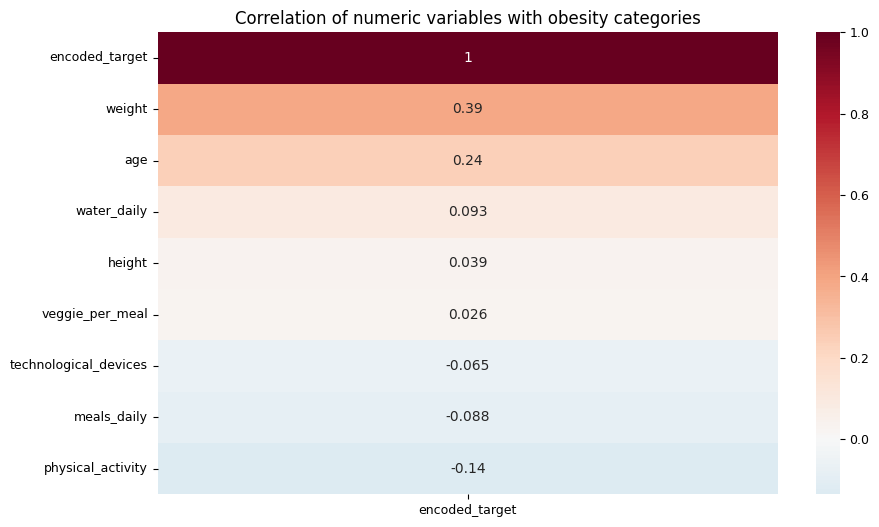

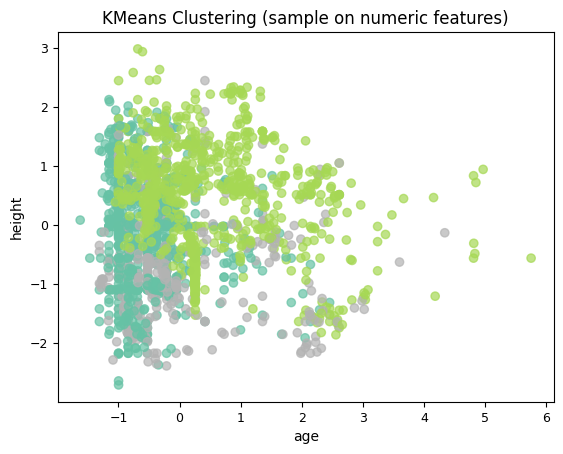

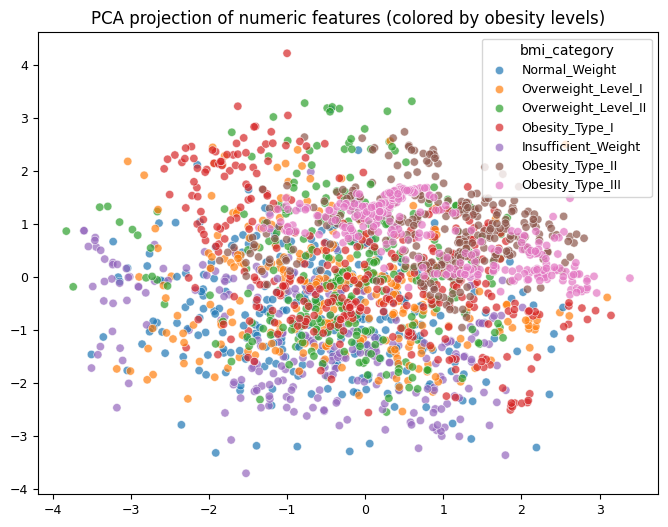

In [16]:
# 1. Correlation between numeric features and encoded categories
encoded_y = y_multiclass.astype("category").cat.codes
cor_df = df[numeric_cols].copy()
cor_df["encoded_target"] = encoded_y
plt.figure(figsize=(10,6))
sns.heatmap(cor_df.corr()[["encoded_target"]].sort_values(by="encoded_target", ascending=False),
            annot=True, cmap="RdBu_r", center=0)
plt.title("Correlation of numeric variables with obesity categories")
plt.show()

# 2. Clustering (KMeans)
if len(numeric_cols) >= 2:
    X_scaled = StandardScaler().fit_transform(df[numeric_cols])
    kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
    plt.scatter(X_scaled[:,0], X_scaled[:,1], c=kmeans.labels_, cmap="Set2", alpha=0.7)
    plt.title("KMeans Clustering (sample on numeric features)")
    plt.xlabel(numeric_cols[0])
    plt.ylabel(numeric_cols[1])
    plt.show()

# 3. PCA projection (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_multiclass, palette="tab10", alpha=0.7)
plt.title("PCA projection of numeric features (colored by obesity levels)")
plt.show()

### 3-Predictive Analytics
We use features except weight and height to predict the obesity risk, and simplify the target into a binary classification problem:  
- 0 = Insufficient_Weight or Normal_Weight   
- 1 = All other categories  

Totally we train 10 models and compare their performance using Accuracy, Precision, Recall, F1, ROC-AUC, training time and prediction latency. Then the best model is delivered as obesity_risk_model.pkl for streamlit dashboard.

LogReg: acc=0.873, f1=0.915, train=0.02s, pred=0.004s
RandomForest_100: acc=0.904, f1=0.934, train=0.20s, pred=0.027s
RandomForest_300: acc=0.916, f1=0.943, train=0.61s, pred=0.014s
DecisionTree: acc=0.883, f1=0.920, train=0.02s, pred=0.000s
SVM_rbf: acc=0.895, f1=0.930, train=0.23s, pred=0.018s
SVM_linear: acc=0.868, f1=0.912, train=0.20s, pred=0.000s
KNN_5: acc=0.861, f1=0.912, train=0.00s, pred=0.020s
KNN_10: acc=0.871, f1=0.917, train=0.00s, pred=0.016s
XGBoost: acc=0.904, f1=0.935, train=0.07s, pred=0.006s


e:\6 KI\8_ML413N Project management and tools for health informatics\PROHI-dashboard-Oberisk\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:17:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\6 KI\8_ML413N Project management and tools for health informatics\PROHI-dashboard-Oberisk\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
e:\6 KI\8_ML413N Project management and tools for health informatics\PROHI-dashboard-Oberisk\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM: acc=0.902, f1=0.934, train=0.07s, pred=0.008s

Best model: RandomForest_300
Final model trained on all data
Model saved as ./models/obesity_risk_model.pkl


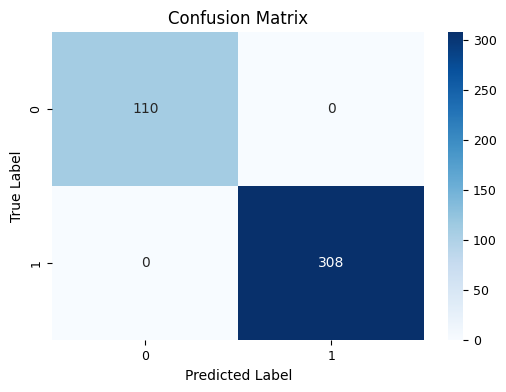

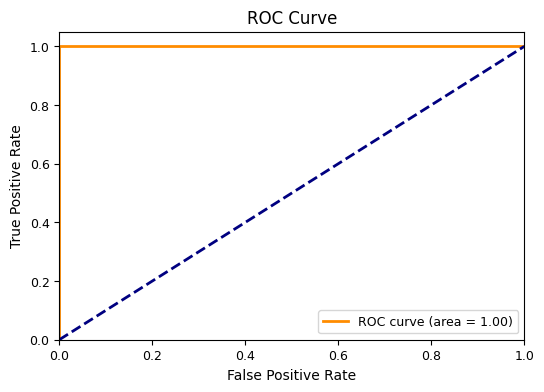

Analysis complete! Model and visualizations saved.


In [30]:
# Define features and target
y = y_multiclass.apply(lambda x: 0 if x in ['Insufficient_Weight', 'Normal_Weight'] else 1)
X = df.drop(columns=[target, "bmi_category","weight","height"])

# Identify numeric and categorical variables
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define 10 model configurations
model_specs = [
    ("LogReg", LogisticRegression(max_iter=1000)),
    ("RandomForest_100", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("RandomForest_300", RandomForestClassifier(n_estimators=300, random_state=42)),
    ("DecisionTree", DecisionTreeClassifier(random_state=42)),
    ("SVM_rbf", SVC(kernel="rbf", probability=True)),
    ("SVM_linear", SVC(kernel="linear", probability=True)),
    ("KNN_5", KNeighborsClassifier(n_neighbors=5)),
    ("KNN_10", KNeighborsClassifier(n_neighbors=10)),
    ("XGBoost", xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)),
    ("LightGBM", lgb.LGBMClassifier(random_state=42, verbose=-1))
]

results = []
for name, clf in model_specs:
    pipe = Pipeline([("preprocess", preprocessor), ("clf", clf)])
    start = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start

    start = time.time()
    y_pred = pipe.predict(X_test)
    pred_time = time.time() - start

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    try:
        y_proba = pipe.predict_proba(X_test)[:,1]
        auc_score = roc_auc_score(y_test, y_proba)
    except Exception:
        auc_score = np.nan

    results.append([name, acc, prec, rec, f1, auc_score, train_time, pred_time])
    print(f"{name}: acc={acc:.3f}, f1={f1:.3f}, train={train_time:.2f}s, pred={pred_time:.3f}s")

results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1","ROC_AUC","Train_s","Pred_s"])
results_df = results_df.sort_values(by="F1", ascending=False)
results_df

# Find best model
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
print(f"\nBest model: {best_model_name}")

# Train final model on all data
best_model_entry = next((m for m in model_specs if m[0] == best_model_name), None)
best_model = best_model_entry[1]

# Build and train the final model
final_model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", best_model)
])

final_model.fit(X, y)
final_model.fit(X, y)
print("Final model trained on all data")

# Save the model
import os
os.makedirs("./models", exist_ok=True)
joblib.dump(final_model, "./models/obesity_risk_model.pkl")
print("Model saved as ./models/obesity_risk_model.pkl")

# Feature importance
if hasattr(final_model, 'feature_importances_'):
    preprocessor.fit(X)
    feature_names = (numeric_cols + 
                     list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))
    
    importances = final_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    print("\nTop 10 Feature Importances:")
    for i in range(10):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances")
    plt.bar(range(10), importances[indices[:10]])
    plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=90)
    plt.tight_layout()
    plt.savefig("./models/feature_importances.png")
    plt.show()

# Confusion matrix and ROC curve for the best model
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig("./models/confusion_matrix.png")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("./models/roc_curve.png")
plt.show()

print("Analysis complete! Model and visualizations saved.")


### 4-Prescriptive Analytics
To understand why the model makes specific predictions, we apply SHAP.  
This allows us to:
- Identify globally important features
- Interpret local predictions for individual instances

SHAP values shape: (2087, 29, 2)
Total number of features: 29

Feature importance ranking:
                  feature  shap_importance
0                     age         0.068099
8       family_history_no         0.058587
14   freq_snack_Sometimes         0.057815
9      family_history_yes         0.052099
13  freq_snack_Frequently         0.037139
5   technological_devices         0.034250
4       physical_activity         0.030678
2             meals_daily         0.023337
3             water_daily         0.021782
1         veggie_per_meal         0.015495
--- Global SHAP Analysis ---


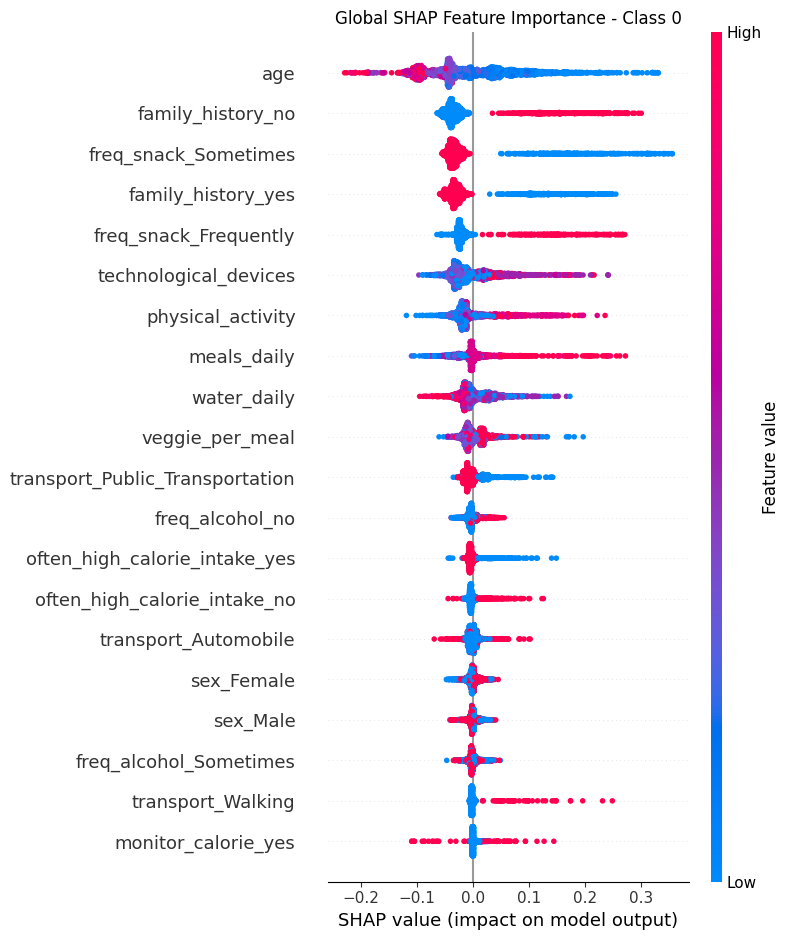

SHAP analysis completed successfully!
Target variable type: <class 'pandas.core.series.Series'>
Target variable unique values: [0 1]
Target variable value counts:
bmi_category
1    1538
0     549
Name: count, dtype: int64
Target variable value counts (proportion):
bmi_category
1    0.736943
0    0.263057
Name: proportion, dtype: float64
First 10 target variable values:
0    0
1    0
2    0
3    1
4    1
5    0
6    0
7    0
8    0
9    0
Name: bmi_category, dtype: int64

=== CLASS INTERPRETATION ===
Based on the target variable conversion logic and distribution:
- Class 0 (549 samples, 26.3%): NON-OBESE category
  (Includes 'Insufficient_Weight' and 'Normal_Weight' from original multiclass data)
- Class 1 (1538 samples, 73.7%): OBESE/OVERWEIGHT category
  (Includes all other BMI categories from original multiclass data)


In [31]:
# Use preprocessed data
model_pipe = joblib.load("./models/obesity_risk_model.pkl")
preprocessor = model_pipe.named_steps['preprocess']
model = model_pipe.named_steps['clf']

# Get preprocessed data
X_transformed = preprocessor.transform(X)

# Get feature names
feature_names = (
    numeric_cols + 
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
)

# Create preprocessed DataFrame
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# SHAP explainer - using preprocessed data
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed)

print("SHAP values shape:", shap_values.shape)
print("Total number of features:", len(feature_names))

shap_values_single = shap_values[:, :, 0]

# Calculate SHAP importance ranking for all features
shap_sum = np.abs(shap_values_single).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'shap_importance': shap_sum
}).sort_values('shap_importance', ascending=False)

print("\nFeature importance ranking:")
print(feature_importance.head(10))

# Global summary - using SHAP values for single class
print("--- Global SHAP Analysis ---")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_single, X_transformed_df, feature_names=feature_names, show=False)
plt.title("Global SHAP Feature Importance - Class 0")
plt.tight_layout()
plt.show()

print("SHAP analysis completed successfully!")

# Check the distribution and specific values of the target variable
print("Target variable type:", type(y))
print("Target variable unique values:", np.unique(y))
print("Target variable value counts:")
print(pd.Series(y).value_counts())
print("Target variable value counts (proportion):")
print(pd.Series(y).value_counts(normalize=True))

# If y is a DataFrame or Series, check the first few samples
if hasattr(y, 'head'):
    print("First 10 target variable values:")
    print(y.head(10))

# Conclusion about class meanings based on the distribution and conversion logic
print("\n=== CLASS INTERPRETATION ===")
print("Based on the target variable conversion logic and distribution:")
print("- Class 0 (549 samples, 26.3%): NON-OBESE category")
print("  (Includes 'Insufficient_Weight' and 'Normal_Weight' from original multiclass data)")
print("- Class 1 (1538 samples, 73.7%): OBESE/OVERWEIGHT category")
print("  (Includes all other BMI categories from original multiclass data)")